

---



# Voice Detection with neural networks
This project implements sound event ***detection***: which is detecting what and importantly ***when*** a sound is occuring. The model input is an audio clip or spectrogram, and the model will output a sequence, such as a class prediction per time-frame.

---

**EnvSpeech** is a dataset created of 5-second, 44.1khz audio clips containing background audio (clips from ESC-50 categories such as rain) and a single speech clip from Librispeech. The speech segments are between 0.5 and 5 seconds long, and can begin anywhere in the clip. **Each soundscape file has an accompanying label file**, which is a 5-dimensional binary vector representing the presence or not of speech for each second (i.e. "bin") of the audio clip. For example, if the speech clip in the soundscape is from 1.1-1.7 seconds in the clip, the label will be [0,1,0,0,0]. The speech can span multiple frames, e.g. if the speech clip is from 1.5-4.5 seconds, the label would be [0,1,1,1,1]. This task is known as "voice activity detection" or "VAD".

---

In [4]:
import pandas as pd
import librosa
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

#### Checking out the data:

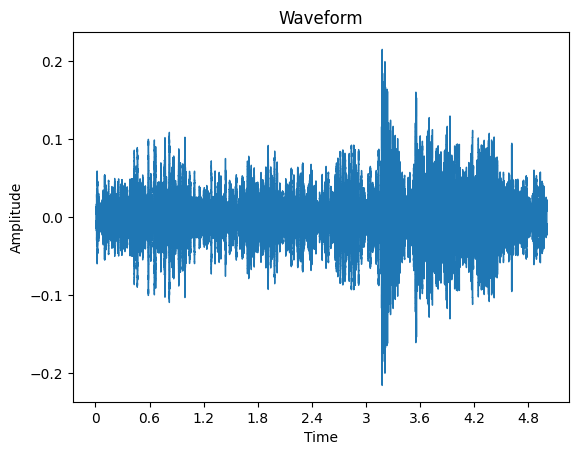

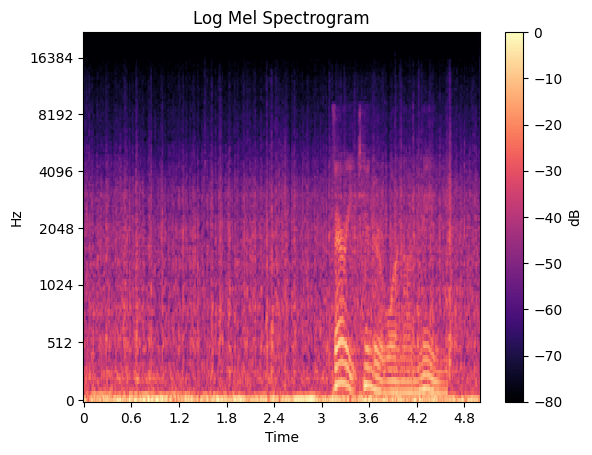

Label (speech presence per second): [0 0 0 1 1]
Metadata for sample:          file_id  split     start       end  speaker_ID
20  soundscape10  train  3.128465  4.595509        2136


In [ ]:
import IPython.display as ipd

audio_dir = "/projects/Machine_Listening/Project_3/EnvSpeechData/audio"  
labels_dir = "/projects/Machine_Listening/Project_3/EnvSpeechData/labels_5"  
metadata_path = "/projects/Machine_Listening/Project_3/EnvSpeechData/env_speech_meta.csv"  

sample_filename = "soundscape10.wav" 
audio_path = os.path.join(audio_dir, sample_filename)

# Load an audio file from EnvSpeech (in audio directory)
y, sr = librosa.load(audio_path, sr=44100)  

# Plot the waveform
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Plot the log mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
librosa.display.specshow(log_mel_spec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(label="dB")
plt.title("Log Mel Spectrogram")
plt.show()

# Play the audio
ipd.display(ipd.Audio(y, rate=sr))

# Load the associated label (in labels_5) and print it
label_path = os.path.join(labels_dir, sample_filename.replace(".wav", ".npy"))
label = np.load(label_path, allow_pickle=True)
print("Label (speech presence per second):", label)

# Load the full metadata csv
metadata = pd.read_csv(metadata_path)
sample_id = sample_filename.replace(".wav", "") 
sample_metadata = metadata[metadata["file_id"] == sample_id]
print("Metadata for sample:", sample_metadata)

## Dataloader for EnvSpeech:


In [ ]:
class EnvSpeechDataset(Dataset):
    def __init__(self, data_dir, data_split, spec_type="log_mel", sr=44100, n_fft=1024, hop_length=512, n_mels=128):
        self.data_dir = data_dir
        dataframe = pd.read_csv(os.path.join(data_dir, 'env_speech_meta.csv'))

        # Metadata CSV has a column `split` that we use to filter
        filtered_df = dataframe[dataframe["split"] == data_split]

        # list of file IDs in this split
        self.file_ids = filtered_df["file_id"].tolist()

        self.spec_type = spec_type
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sr = sr

        print(f'Num files in {data_split}: {len(self.file_ids)}')

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        
        # label and audio filepaths
        audio_path = os.path.join(self.data_dir, f'audio/{self.file_ids[idx]}.wav')
        label_path = os.path.join(self.data_dir, f'labels_5/{self.file_ids[idx]}.npy')
        
        # wavefrom at the specified sample rate
        y, _ = librosa.load(audio_path, sr=self.sr)
        
        # associated numpy label
        label = np.load(label_path, allow_pickle=True)
        
        # given a spectrogram argument self.spec_type, compute the appropriate feature (lin_pwr, log, log_mel)
        if self.spec_type == "lin_pwr":
            spectrogram = np.abs(librosa.stft(y, n_fft=self.n_fft, hop_length=self.hop_length)) ** 2
        elif self.spec_type == "log":
            spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=self.n_fft, hop_length=self.hop_length)))
        elif self.spec_type == "log_mel":
            mel_spec = librosa.feature.melspectrogram(y=y, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
            spectrogram = librosa.power_to_db(mel_spec, ref=np.max)
            
        # spectrogram normalization
        spectrogram = (spectrogram - spectrogram.mean()) / (spectrogram.std() + 1e-6)

        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)
        
        return spectrogram, label

In [ ]:
# Instantiate EnvSpeech class and dataloader
data_dir = '/projects/Machine_Listening/Project_3/EnvSpeechData'
data_split = "train"  
dataset = EnvSpeechDataset(data_dir, data_split)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print('my dataloader shapes')
for spectrograms, labels in dataloader:
    print(f"Spectrogram shape: {spectrograms.shape}")  
    print(f"Label shape: {labels.shape}")  
    break

Num files in train: 3500
my dataloader shapes
Spectrogram shape: torch.Size([32, 1, 128, 431])
Label shape: torch.Size([32, 5])




---



## Vocal activity detection model design
We'll be using Conv-2D for frame-wise voice activity detection to take advantage of the full spatio-temporal benefits that convolutional layers have to offer. For this model:
- **Model input**: a log-mel spectrogram and it's associated voice detection array, a binary vectory signaling detection in a given frame (second of audio) if 1, else 0. Shape: `(batch, 128, 431)` and `(batch, 5)`
- **Model output**: a vector of probabilities over the number of frames ("classes"). Shape:  `(batch, 5)`

In [ ]:
class CNNFrameClassifier(nn.Module):
    def __init__(self, input_channels=1, num_out_frames=5):  # 1 "class" per second
        """
        A Convolutional Neural Network (CNN) for frame-wise classification.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for spectrograms).
            num_out_frames (int): Number of time steps in the output (e.g., per-second predictions).
        """
        super(CNNFrameClassifier, self).__init__()

        # First convolutional layer: a 3x3 convolution to extract basic features
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1  
        )
        self.bn1 = nn.BatchNorm2d(16)  # Normalization for stability

        # Second convolutional layer: Extract deeper feature representations
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Third convolutional layer: Further increase feature complexity
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv_out = nn.Conv2d(64, 1, kernel_size=(32, 1))

        # Adaptive pooling ensures that we get exactly `num_out_frames` time steps in the output
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, num_out_frames))

    def forward(self, x):
        """
        Forward pass of the CNN.

        Args:
            x (Tensor): Input tensor of shape (batch, channels, frequency, time).

        Returns:
            Tensor: Predictions of shape (batch, num_out_frames, 1).
        """

        x = F.relu(self.bn1(self.conv1(x)))  # Apply first convolution + activation
        x = F.max_pool2d(x, (2, 2))  # Downsample the feature map

        x = F.relu(self.bn2(self.conv2(x)))  # Apply second convolution + activation
        x = F.max_pool2d(x, (2, 2))  # Further downsample

        x = F.relu(self.bn3(self.conv3(x)))  # Third convolution + activation

        x = self.conv_out(x)  # Collapse frequency dimension

        x = self.adaptive_pool(x)  # Ensure fixed output time steps

        # Reshape the output to match the expected format (batch, num_out_frames, 1)
        x = x.squeeze(2).permute(0, 2, 1) 

        return x  # Predictions per time step

vad_model = CNNFrameClassifier(num_out_frames=10)
summary(vad_model, input_size=(4,1, 128, 431))

Layer (type:depth-idx)                   Output Shape              Param #
CNNFrameClassifier                       [4, 10, 1]                --
├─Conv2d: 1-1                            [4, 16, 128, 431]         160
├─BatchNorm2d: 1-2                       [4, 16, 128, 431]         32
├─Conv2d: 1-3                            [4, 32, 64, 215]          4,640
├─BatchNorm2d: 1-4                       [4, 32, 64, 215]          64
├─Conv2d: 1-5                            [4, 64, 32, 107]          18,496
├─BatchNorm2d: 1-6                       [4, 64, 32, 107]          128
├─Conv2d: 1-7                            [4, 1, 1, 107]            2,049
├─AdaptiveAvgPool2d: 1-8                 [4, 1, 1, 10]             --
Total params: 25,569
Trainable params: 25,569
Non-trainable params: 0
Total mult-adds (M): 544.89
Input size (MB): 0.88
Forward/backward pass size (MB): 98.70
Params size (MB): 0.10
Estimated Total Size (MB): 99.69



---



## Training voice activity detection model:
Below, set up your model training and validation script using the model defined above. A few tips for this task:

- We use `torch.nn.BCEWithLogitsLoss` for the loss here, since we are framing this as a multi-label classification.
- Because this is a multi-label problem, the accuracy metrics are a bit trickier. For simplicity, here we'll work with these two metrics:
    - **"per-sample" accuracy**: for every item in the predicted array (of dimension 5), measure if this binary prediction is correct. This treats each index individually. The **random baseline** here is 50%, as it is essentially an individual binary classification problem.
    - **"exact-match" accuracy**: if every index in the predicted output is correct, this = 1, else 0. For example, a prediction of [1,1,0,0,0] for a target [1,1,0,0,0] would be correct, but anything else would be incorrect. This is a more difficult metric. The **random baseline** here is 0.5^5 = 0.03125 = 3.125%, measuring the independent chance of each frame label being correct


In [ ]:
def train_and_validate_voice_detection(model, device, train_dataloader, val_dataloader, num_epochs, lr=0.001):
    """
    Train and validate your voice detection CNN.

    Parameters:
        model : Instantiation of CNNFrameClassifier model.
        device (str): The device to use for training ('cuda' or 'cpu').
        lr (float): The learning rate for the optimizer.
        train_dataloader (DataLoader): The dataloader for training data.
        val_dataloader (DataLoader): The dataloader for validation data.
        num_epochs (int): The number of epochs to train the model.
    Returns:
        Arrays of training and validation losses and accuracies.
    """
    model = model.to(device)

    # Optimizer setup
    opt = torch.optim.SGD(model.parameters(), lr=lr)

    # Loss function
    loss_fn = nn.BCEWithLogitsLoss().to(device)

    best_val_accuracy = 0.0
    all_train_loss_epochs = []
    all_train_acc_epochs = []
    all_val_loss_epochs = []
    all_val_acc_epochs = []

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_correct_train = 0
        total_exact_matches_train = 0
        total_samples = 0

        model.train()

        for inputs, targets in tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}/{num_epochs}"):

            inputs, targets = inputs.to(device), targets.to(device)
            opt.zero_grad()
            outputs = model(inputs).squeeze(-1)
            loss = loss_fn(outputs, targets)
            total_train_loss += loss.item()
            loss.backward()
            opt.step()

            # Compute training accuracy metrics 
            predicted_probs = torch.sigmoid(outputs)  
            predicted_labels = (predicted_probs > 0.5).float()  

            # Per-label accuracy (averaged across all batch samples)
            per_label_acc = (predicted_labels == targets).float().mean()
            total_correct_train += per_label_acc.item()

            # Exact match accuracy (1 if all labels match, 0 otherwise)
            exact_match_acc = (predicted_labels == targets).all(dim=1).float().mean()
            total_exact_matches_train += exact_match_acc.item()

            total_samples += 1

        avg_train_loss = total_train_loss / total_samples
        train_per_label_acc = total_correct_train / total_samples
        train_exact_match_acc = total_exact_matches_train / total_samples

        all_train_loss_epochs.append(avg_train_loss)
        all_train_acc_epochs.append(train_exact_match_acc)

        print(f"Train Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Per-Label Accuracy: {train_per_label_acc:.4f}, Exact Match Accuracy: {train_exact_match_acc:.4f}")

        # VALIDATION LOOP
        total_val_loss = 0.0
        total_correct_val = 0
        total_exact_matches_val = 0
        total_val_samples = 0
        
        model.eval()

        with torch.no_grad():
            for inputs, targets in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(-1)
                loss = loss_fn(outputs, targets)
                total_val_loss += loss.item()
                
                # Compute validation accuracy metrics
                predicted_probs = torch.sigmoid(outputs)
                predicted_labels = (predicted_probs > 0.5).float()

                # Per-label accuracy
                per_label_acc = (predicted_labels == targets).float().mean()
                total_correct_val += per_label_acc.item()

                # Exact match accuracy
                exact_match_acc = (predicted_labels == targets).all(dim=1).float().mean()
                total_exact_matches_val += exact_match_acc.item()

                total_val_samples += 1

        

        avg_val_loss = total_val_loss / total_val_samples
        val_per_label_acc = total_correct_val / total_val_samples
        val_exact_match_acc = total_exact_matches_val / total_val_samples

        all_val_loss_epochs.append(avg_val_loss)
        all_val_acc_epochs.append(val_exact_match_acc) 

        print(f"Validation Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Per-Label Accuracy: {val_per_label_acc:.4f}, Exact Match Accuracy: {val_exact_match_acc:.4f}\n")

        if val_exact_match_acc > best_val_accuracy:
            best_val_accuracy = val_exact_match_acc
            torch.save(model.state_dict(), "best_model_voice_detection.pth")
            print(f"Best model updated with validation accuracy: {best_val_accuracy:.4f}")

    return all_train_loss_epochs, all_train_acc_epochs, all_val_loss_epochs, all_val_acc_epochs


In [11]:
# Set up dataloadewrs
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ', device)

train_dataset = EnvSpeechDataset(data_dir, data_split="train")
train_dataloader = train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = EnvSpeechDataset(data_dir, data_split="val")
val_dataloader = val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = EnvSpeechDataset(data_dir, data_split="test")
test_dataloader = test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Device:  cuda
Num files in train: 3500
Num files in val: 750
Num files in test: 750


In [ ]:
model = CNNFrameClassifier(input_channels=1, num_out_frames=5)
tr_loss_ep,tr_acc_ep, val_loss_ep, val_acc_ep = train_and_validate_voice_detection(model=model,
                                                                    device=device,
                                                                    train_dataloader=train_dataloader,
                                                                    val_dataloader=val_dataloader,
                                                                    num_epochs=50,
                                                                    lr=0.001) # I found LR=0.001 to be most successful here, but something to play with


Train Epoch 1/50: 100%|██████████| 110/110 [02:19<00:00,  1.27s/it]


Train Epoch 1/50, Train Loss: 0.6312, Per-Label Accuracy: 0.7152, Exact Match Accuracy: 0.2307


Validation Epoch 1/50: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it]


Validation Epoch 1/50, Validation Loss: 0.5841, Per-Label Accuracy: 0.7839, Exact Match Accuracy: 0.3064

Best model updated with validation accuracy: 0.3064


Train Epoch 2/50: 100%|██████████| 110/110 [01:47<00:00,  1.02it/s]


Train Epoch 2/50, Train Loss: 0.5484, Per-Label Accuracy: 0.7969, Exact Match Accuracy: 0.3298


Validation Epoch 2/50: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Validation Epoch 2/50, Validation Loss: 0.5235, Per-Label Accuracy: 0.8036, Exact Match Accuracy: 0.3294

Best model updated with validation accuracy: 0.3294


Train Epoch 3/50: 100%|██████████| 110/110 [01:47<00:00,  1.03it/s]


Train Epoch 3/50, Train Loss: 0.4988, Per-Label Accuracy: 0.8060, Exact Match Accuracy: 0.3426


Validation Epoch 3/50: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


Validation Epoch 3/50, Validation Loss: 0.4840, Per-Label Accuracy: 0.8160, Exact Match Accuracy: 0.3770

Best model updated with validation accuracy: 0.3770


Train Epoch 4/50: 100%|██████████| 110/110 [01:39<00:00,  1.10it/s]


Train Epoch 4/50, Train Loss: 0.4656, Per-Label Accuracy: 0.8163, Exact Match Accuracy: 0.3650


Validation Epoch 4/50: 100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


Validation Epoch 4/50, Validation Loss: 0.4577, Per-Label Accuracy: 0.8212, Exact Match Accuracy: 0.3744



Train Epoch 5/50: 100%|██████████| 110/110 [01:40<00:00,  1.10it/s]


Train Epoch 5/50, Train Loss: 0.4419, Per-Label Accuracy: 0.8259, Exact Match Accuracy: 0.3812


Validation Epoch 5/50: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


Validation Epoch 5/50, Validation Loss: 0.4356, Per-Label Accuracy: 0.8305, Exact Match Accuracy: 0.3949

Best model updated with validation accuracy: 0.3949


Train Epoch 6/50: 100%|██████████| 110/110 [01:37<00:00,  1.13it/s]


Train Epoch 6/50, Train Loss: 0.4233, Per-Label Accuracy: 0.8300, Exact Match Accuracy: 0.3884


Validation Epoch 6/50: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s]


Validation Epoch 6/50, Validation Loss: 0.4204, Per-Label Accuracy: 0.8338, Exact Match Accuracy: 0.3984

Best model updated with validation accuracy: 0.3984


Train Epoch 7/50: 100%|██████████| 110/110 [01:43<00:00,  1.07it/s]


Train Epoch 7/50, Train Loss: 0.4071, Per-Label Accuracy: 0.8375, Exact Match Accuracy: 0.4081


Validation Epoch 7/50: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Validation Epoch 7/50, Validation Loss: 0.4053, Per-Label Accuracy: 0.8417, Exact Match Accuracy: 0.4262

Best model updated with validation accuracy: 0.4262


Train Epoch 8/50: 100%|██████████| 110/110 [01:52<00:00,  1.02s/it]


Train Epoch 8/50, Train Loss: 0.3953, Per-Label Accuracy: 0.8448, Exact Match Accuracy: 0.4206


Validation Epoch 8/50: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]


Validation Epoch 8/50, Validation Loss: 0.3944, Per-Label Accuracy: 0.8434, Exact Match Accuracy: 0.4275

Best model updated with validation accuracy: 0.4275


Train Epoch 9/50: 100%|██████████| 110/110 [02:01<00:00,  1.10s/it]


Train Epoch 9/50, Train Loss: 0.3817, Per-Label Accuracy: 0.8506, Exact Match Accuracy: 0.4320


Validation Epoch 9/50: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


Validation Epoch 9/50, Validation Loss: 0.3820, Per-Label Accuracy: 0.8484, Exact Match Accuracy: 0.4366

Best model updated with validation accuracy: 0.4366


Train Epoch 10/50: 100%|██████████| 110/110 [01:55<00:00,  1.05s/it]


Train Epoch 10/50, Train Loss: 0.3718, Per-Label Accuracy: 0.8573, Exact Match Accuracy: 0.4531


Validation Epoch 10/50: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Validation Epoch 10/50, Validation Loss: 0.3858, Per-Label Accuracy: 0.8388, Exact Match Accuracy: 0.3828



Train Epoch 11/50: 100%|██████████| 110/110 [01:54<00:00,  1.04s/it]


Train Epoch 11/50, Train Loss: 0.3624, Per-Label Accuracy: 0.8614, Exact Match Accuracy: 0.4626


Validation Epoch 11/50: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


Validation Epoch 11/50, Validation Loss: 0.3635, Per-Label Accuracy: 0.8563, Exact Match Accuracy: 0.4656

Best model updated with validation accuracy: 0.4656


Train Epoch 12/50: 100%|██████████| 110/110 [02:09<00:00,  1.18s/it]


Train Epoch 12/50, Train Loss: 0.3529, Per-Label Accuracy: 0.8640, Exact Match Accuracy: 0.4658


Validation Epoch 12/50: 100%|██████████| 24/24 [00:26<00:00,  1.11s/it]


Validation Epoch 12/50, Validation Loss: 0.3583, Per-Label Accuracy: 0.8564, Exact Match Accuracy: 0.4297



Train Epoch 13/50: 100%|██████████| 110/110 [02:03<00:00,  1.12s/it]


Train Epoch 13/50, Train Loss: 0.3461, Per-Label Accuracy: 0.8668, Exact Match Accuracy: 0.4741


Validation Epoch 13/50: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


Validation Epoch 13/50, Validation Loss: 0.3487, Per-Label Accuracy: 0.8596, Exact Match Accuracy: 0.4457



Train Epoch 14/50: 100%|██████████| 110/110 [02:02<00:00,  1.11s/it]


Train Epoch 14/50, Train Loss: 0.3382, Per-Label Accuracy: 0.8710, Exact Match Accuracy: 0.4865


Validation Epoch 14/50: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Validation Epoch 14/50, Validation Loss: 0.3522, Per-Label Accuracy: 0.8549, Exact Match Accuracy: 0.4275



Train Epoch 15/50: 100%|██████████| 110/110 [01:59<00:00,  1.08s/it]


Train Epoch 15/50, Train Loss: 0.3320, Per-Label Accuracy: 0.8725, Exact Match Accuracy: 0.4920


Validation Epoch 15/50: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Validation Epoch 15/50, Validation Loss: 0.3363, Per-Label Accuracy: 0.8657, Exact Match Accuracy: 0.4929

Best model updated with validation accuracy: 0.4929


Train Epoch 16/50: 100%|██████████| 110/110 [02:04<00:00,  1.13s/it]


Train Epoch 16/50, Train Loss: 0.3274, Per-Label Accuracy: 0.8744, Exact Match Accuracy: 0.4948


Validation Epoch 16/50: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


Validation Epoch 16/50, Validation Loss: 0.3487, Per-Label Accuracy: 0.8628, Exact Match Accuracy: 0.5033

Best model updated with validation accuracy: 0.5033


Train Epoch 17/50: 100%|██████████| 110/110 [02:02<00:00,  1.12s/it]


Train Epoch 17/50, Train Loss: 0.3223, Per-Label Accuracy: 0.8761, Exact Match Accuracy: 0.4965


Validation Epoch 17/50: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


Validation Epoch 17/50, Validation Loss: 0.3251, Per-Label Accuracy: 0.8721, Exact Match Accuracy: 0.4847



Train Epoch 18/50: 100%|██████████| 110/110 [02:04<00:00,  1.13s/it]


Train Epoch 18/50, Train Loss: 0.3181, Per-Label Accuracy: 0.8800, Exact Match Accuracy: 0.5126


Validation Epoch 18/50: 100%|██████████| 24/24 [00:26<00:00,  1.11s/it]


Validation Epoch 18/50, Validation Loss: 0.3527, Per-Label Accuracy: 0.8587, Exact Match Accuracy: 0.4998



Train Epoch 19/50: 100%|██████████| 110/110 [02:01<00:00,  1.11s/it]


Train Epoch 19/50, Train Loss: 0.3150, Per-Label Accuracy: 0.8802, Exact Match Accuracy: 0.5134


Validation Epoch 19/50: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


Validation Epoch 19/50, Validation Loss: 0.3215, Per-Label Accuracy: 0.8703, Exact Match Accuracy: 0.4717



Train Epoch 20/50: 100%|██████████| 110/110 [02:07<00:00,  1.16s/it]


Train Epoch 20/50, Train Loss: 0.3096, Per-Label Accuracy: 0.8826, Exact Match Accuracy: 0.5203


Validation Epoch 20/50: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


Validation Epoch 20/50, Validation Loss: 0.3216, Per-Label Accuracy: 0.8690, Exact Match Accuracy: 0.4717



Train Epoch 21/50: 100%|██████████| 110/110 [02:15<00:00,  1.23s/it]


Train Epoch 21/50, Train Loss: 0.3083, Per-Label Accuracy: 0.8843, Exact Match Accuracy: 0.5259


Validation Epoch 21/50: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it]


Validation Epoch 21/50, Validation Loss: 0.3254, Per-Label Accuracy: 0.8645, Exact Match Accuracy: 0.4531



Train Epoch 22/50: 100%|██████████| 110/110 [02:19<00:00,  1.27s/it]


Train Epoch 22/50, Train Loss: 0.3052, Per-Label Accuracy: 0.8847, Exact Match Accuracy: 0.5254


Validation Epoch 22/50: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


Validation Epoch 22/50, Validation Loss: 0.3621, Per-Label Accuracy: 0.8517, Exact Match Accuracy: 0.4833



Train Epoch 23/50: 100%|██████████| 110/110 [02:04<00:00,  1.13s/it]


Train Epoch 23/50, Train Loss: 0.3015, Per-Label Accuracy: 0.8867, Exact Match Accuracy: 0.5317


Validation Epoch 23/50: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Validation Epoch 23/50, Validation Loss: 0.3389, Per-Label Accuracy: 0.8545, Exact Match Accuracy: 0.4150



Train Epoch 24/50: 100%|██████████| 110/110 [02:05<00:00,  1.15s/it]


Train Epoch 24/50, Train Loss: 0.3007, Per-Label Accuracy: 0.8870, Exact Match Accuracy: 0.5351


Validation Epoch 24/50: 100%|██████████| 24/24 [00:26<00:00,  1.11s/it]


Validation Epoch 24/50, Validation Loss: 0.3105, Per-Label Accuracy: 0.8723, Exact Match Accuracy: 0.4766



Train Epoch 25/50: 100%|██████████| 110/110 [02:02<00:00,  1.12s/it]


Train Epoch 25/50, Train Loss: 0.2947, Per-Label Accuracy: 0.8892, Exact Match Accuracy: 0.5408


Validation Epoch 25/50: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


Validation Epoch 25/50, Validation Loss: 0.2965, Per-Label Accuracy: 0.8859, Exact Match Accuracy: 0.5467

Best model updated with validation accuracy: 0.5467


Train Epoch 26/50: 100%|██████████| 110/110 [02:01<00:00,  1.11s/it]


Train Epoch 26/50, Train Loss: 0.2926, Per-Label Accuracy: 0.8904, Exact Match Accuracy: 0.5437


Validation Epoch 26/50: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]


Validation Epoch 26/50, Validation Loss: 0.2986, Per-Label Accuracy: 0.8854, Exact Match Accuracy: 0.5506

Best model updated with validation accuracy: 0.5506


Train Epoch 27/50: 100%|██████████| 110/110 [02:06<00:00,  1.15s/it]


Train Epoch 27/50, Train Loss: 0.2888, Per-Label Accuracy: 0.8915, Exact Match Accuracy: 0.5493


Validation Epoch 27/50: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Validation Epoch 27/50, Validation Loss: 0.3093, Per-Label Accuracy: 0.8767, Exact Match Accuracy: 0.5333



Train Epoch 28/50: 100%|██████████| 110/110 [02:06<00:00,  1.15s/it]


Train Epoch 28/50, Train Loss: 0.2887, Per-Label Accuracy: 0.8907, Exact Match Accuracy: 0.5473


Validation Epoch 28/50: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Validation Epoch 28/50, Validation Loss: 0.3033, Per-Label Accuracy: 0.8765, Exact Match Accuracy: 0.4922



Train Epoch 29/50: 100%|██████████| 110/110 [02:09<00:00,  1.18s/it]


Train Epoch 29/50, Train Loss: 0.2855, Per-Label Accuracy: 0.8926, Exact Match Accuracy: 0.5492


Validation Epoch 29/50: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]


Validation Epoch 29/50, Validation Loss: 0.2961, Per-Label Accuracy: 0.8841, Exact Match Accuracy: 0.5506



Train Epoch 30/50: 100%|██████████| 110/110 [02:11<00:00,  1.19s/it]


Train Epoch 30/50, Train Loss: 0.2831, Per-Label Accuracy: 0.8944, Exact Match Accuracy: 0.5602


Validation Epoch 30/50: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it]


Validation Epoch 30/50, Validation Loss: 0.3165, Per-Label Accuracy: 0.8638, Exact Match Accuracy: 0.4462



Train Epoch 31/50: 100%|██████████| 110/110 [02:18<00:00,  1.26s/it]


Train Epoch 31/50, Train Loss: 0.2836, Per-Label Accuracy: 0.8936, Exact Match Accuracy: 0.5581


Validation Epoch 31/50: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


Validation Epoch 31/50, Validation Loss: 0.2876, Per-Label Accuracy: 0.8890, Exact Match Accuracy: 0.5558

Best model updated with validation accuracy: 0.5558


Train Epoch 32/50: 100%|██████████| 110/110 [02:07<00:00,  1.16s/it]


Train Epoch 32/50, Train Loss: 0.2767, Per-Label Accuracy: 0.8965, Exact Match Accuracy: 0.5657


Validation Epoch 32/50: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


Validation Epoch 32/50, Validation Loss: 0.3108, Per-Label Accuracy: 0.8798, Exact Match Accuracy: 0.5526



Train Epoch 33/50: 100%|██████████| 110/110 [02:13<00:00,  1.22s/it]


Train Epoch 33/50, Train Loss: 0.2777, Per-Label Accuracy: 0.8969, Exact Match Accuracy: 0.5654


Validation Epoch 33/50: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


Validation Epoch 33/50, Validation Loss: 0.3588, Per-Label Accuracy: 0.8411, Exact Match Accuracy: 0.3837



Train Epoch 34/50: 100%|██████████| 110/110 [02:16<00:00,  1.24s/it]


Train Epoch 34/50, Train Loss: 0.2732, Per-Label Accuracy: 0.8995, Exact Match Accuracy: 0.5744


Validation Epoch 34/50: 100%|██████████| 24/24 [00:31<00:00,  1.31s/it]


Validation Epoch 34/50, Validation Loss: 0.2788, Per-Label Accuracy: 0.8878, Exact Match Accuracy: 0.5251



Train Epoch 35/50: 100%|██████████| 110/110 [02:16<00:00,  1.24s/it]


Train Epoch 35/50, Train Loss: 0.2702, Per-Label Accuracy: 0.9008, Exact Match Accuracy: 0.5815


Validation Epoch 35/50: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


Validation Epoch 35/50, Validation Loss: 0.2841, Per-Label Accuracy: 0.8920, Exact Match Accuracy: 0.5640

Best model updated with validation accuracy: 0.5640


Train Epoch 36/50: 100%|██████████| 110/110 [02:10<00:00,  1.19s/it]


Train Epoch 36/50, Train Loss: 0.2686, Per-Label Accuracy: 0.8993, Exact Match Accuracy: 0.5730


Validation Epoch 36/50: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


Validation Epoch 36/50, Validation Loss: 0.2908, Per-Label Accuracy: 0.8812, Exact Match Accuracy: 0.5061



Train Epoch 37/50: 100%|██████████| 110/110 [02:18<00:00,  1.26s/it]


Train Epoch 37/50, Train Loss: 0.2663, Per-Label Accuracy: 0.9015, Exact Match Accuracy: 0.5804


Validation Epoch 37/50: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


Validation Epoch 37/50, Validation Loss: 0.2705, Per-Label Accuracy: 0.8925, Exact Match Accuracy: 0.5394



Train Epoch 38/50: 100%|██████████| 110/110 [02:11<00:00,  1.20s/it]


Train Epoch 38/50, Train Loss: 0.2647, Per-Label Accuracy: 0.9028, Exact Match Accuracy: 0.5869


Validation Epoch 38/50: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


Validation Epoch 38/50, Validation Loss: 0.2641, Per-Label Accuracy: 0.8978, Exact Match Accuracy: 0.5632



Train Epoch 39/50: 100%|██████████| 110/110 [02:11<00:00,  1.20s/it]


Train Epoch 39/50, Train Loss: 0.2639, Per-Label Accuracy: 0.9022, Exact Match Accuracy: 0.5839


Validation Epoch 39/50: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


Validation Epoch 39/50, Validation Loss: 0.2700, Per-Label Accuracy: 0.8922, Exact Match Accuracy: 0.5365



Train Epoch 40/50: 100%|██████████| 110/110 [02:09<00:00,  1.17s/it]


Train Epoch 40/50, Train Loss: 0.2629, Per-Label Accuracy: 0.9026, Exact Match Accuracy: 0.5866


Validation Epoch 40/50: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


Validation Epoch 40/50, Validation Loss: 0.3310, Per-Label Accuracy: 0.8715, Exact Match Accuracy: 0.5435



Train Epoch 41/50: 100%|██████████| 110/110 [02:08<00:00,  1.16s/it]


Train Epoch 41/50, Train Loss: 0.2610, Per-Label Accuracy: 0.9047, Exact Match Accuracy: 0.5953


Validation Epoch 41/50: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]


Validation Epoch 41/50, Validation Loss: 0.2675, Per-Label Accuracy: 0.8927, Exact Match Accuracy: 0.5391



Train Epoch 42/50: 100%|██████████| 110/110 [02:16<00:00,  1.24s/it]


Train Epoch 42/50, Train Loss: 0.2588, Per-Label Accuracy: 0.9045, Exact Match Accuracy: 0.5929


Validation Epoch 42/50: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


Validation Epoch 42/50, Validation Loss: 0.2894, Per-Label Accuracy: 0.8811, Exact Match Accuracy: 0.5074



Train Epoch 43/50: 100%|██████████| 110/110 [02:15<00:00,  1.23s/it]


Train Epoch 43/50, Train Loss: 0.2563, Per-Label Accuracy: 0.9043, Exact Match Accuracy: 0.5935


Validation Epoch 43/50: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


Validation Epoch 43/50, Validation Loss: 0.2680, Per-Label Accuracy: 0.9008, Exact Match Accuracy: 0.5926

Best model updated with validation accuracy: 0.5926


Train Epoch 44/50: 100%|██████████| 110/110 [02:13<00:00,  1.22s/it]


Train Epoch 44/50, Train Loss: 0.2536, Per-Label Accuracy: 0.9069, Exact Match Accuracy: 0.6009


Validation Epoch 44/50: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


Validation Epoch 44/50, Validation Loss: 0.2696, Per-Label Accuracy: 0.8898, Exact Match Accuracy: 0.5326



Train Epoch 45/50: 100%|██████████| 110/110 [02:13<00:00,  1.21s/it]


Train Epoch 45/50, Train Loss: 0.2541, Per-Label Accuracy: 0.9061, Exact Match Accuracy: 0.6000


Validation Epoch 45/50: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


Validation Epoch 45/50, Validation Loss: 0.2526, Per-Label Accuracy: 0.9043, Exact Match Accuracy: 0.5854



Train Epoch 46/50: 100%|██████████| 110/110 [02:15<00:00,  1.23s/it]


Train Epoch 46/50, Train Loss: 0.2528, Per-Label Accuracy: 0.9073, Exact Match Accuracy: 0.6041


Validation Epoch 46/50: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it]


Validation Epoch 46/50, Validation Loss: 0.2564, Per-Label Accuracy: 0.8979, Exact Match Accuracy: 0.5560



Train Epoch 47/50: 100%|██████████| 110/110 [02:16<00:00,  1.24s/it]


Train Epoch 47/50, Train Loss: 0.2495, Per-Label Accuracy: 0.9091, Exact Match Accuracy: 0.6071


Validation Epoch 47/50: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]


Validation Epoch 47/50, Validation Loss: 0.2523, Per-Label Accuracy: 0.9012, Exact Match Accuracy: 0.5685



Train Epoch 48/50: 100%|██████████| 110/110 [02:15<00:00,  1.23s/it]


Train Epoch 48/50, Train Loss: 0.2509, Per-Label Accuracy: 0.9064, Exact Match Accuracy: 0.5994


Validation Epoch 48/50: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


Validation Epoch 48/50, Validation Loss: 0.2566, Per-Label Accuracy: 0.9047, Exact Match Accuracy: 0.5991

Best model updated with validation accuracy: 0.5991


Train Epoch 49/50: 100%|██████████| 110/110 [02:11<00:00,  1.19s/it]


Train Epoch 49/50, Train Loss: 0.2483, Per-Label Accuracy: 0.9091, Exact Match Accuracy: 0.6090


Validation Epoch 49/50: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


Validation Epoch 49/50, Validation Loss: 0.2788, Per-Label Accuracy: 0.8975, Exact Match Accuracy: 0.6099

Best model updated with validation accuracy: 0.6099


Train Epoch 50/50: 100%|██████████| 110/110 [02:13<00:00,  1.21s/it]


Train Epoch 50/50, Train Loss: 0.2456, Per-Label Accuracy: 0.9107, Exact Match Accuracy: 0.6140


Validation Epoch 50/50: 100%|██████████| 24/24 [00:27<00:00,  1.17s/it]

Validation Epoch 50/50, Validation Loss: 0.2456, Per-Label Accuracy: 0.9080, Exact Match Accuracy: 0.6023



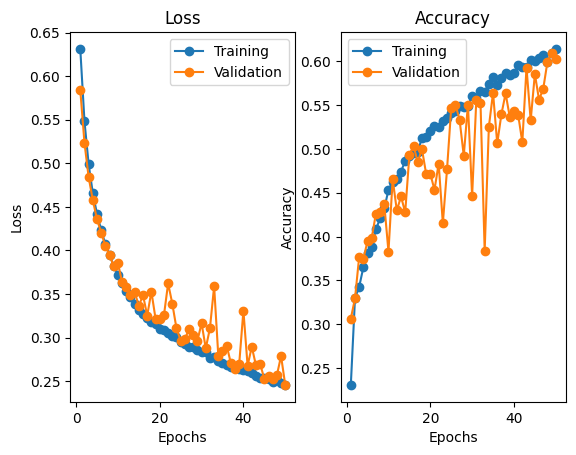

In [ ]:
# Plotting

num_epochs=50
epochs = range(1, num_epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss_ep, label='Training', marker='o')
plt.plot(epochs, val_loss_ep, label='Validation', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc_ep, label='Training', marker='o')
plt.plot(epochs, val_acc_ep, label='Validation', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()




---



## Evaluation:

In [ ]:
def load_best_model_voice_detection(device):
    """
    Load the best saved model from the file system.

    Parameters:
        device (str): The device to load the model onto ('cuda' or 'cpu').

    Returns:
        model: The loaded model with trained weights.
    """
    model.load_state_dict(torch.load(f"best_model_voice_detection.pth", map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded best model: best_model_detection.pth")
    return model


def eval_model_voice_detection(model, test_dataloader, device):
    """
    Test the loaded model on a test dataset.

    Parameters:
        model: The trained model to evaluate.
        test_dataloader (DataLoader): The dataloader for test data.
        device (str): The device to use for testing ('cuda' or 'cpu').

    Returns:
        results_dict (dict): Dictionary of average per-sample and exact match accuracies.
    """
    model.eval()

    total_samples = 0
    correct_per_sample = 0
    exact_match_count = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader, desc="Testing Model"):

            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)  
            predicted = torch.round(torch.sigmoid(outputs))

            correct_per_sample += (predicted.squeeze() == targets).float().mean().item() * inputs.shape[0]

            exact_match_count += (predicted.squeeze() == targets).all(dim=1).sum().item()

            total_samples += inputs.shape[0]
            
    results_dict = {
        'avg_per_sample_acc': correct_per_sample / total_samples,
        'avg_exact_match_acc': exact_match_count / total_samples
    }

    return results_dict


In [ ]:
trained_model_cnn = load_best_model_voice_detection(device)
trained_model_cnn.eval()
results_cnn = eval_model_voice_detection(trained_model_cnn, test_dataloader, device)
print(results_cnn)

Loaded best model: best_model_detection.pth


Testing Model: 100%|██████████| 24/24 [00:31<00:00,  1.33s/it]

{'avg_per_sample_acc': 0.8840000117619833, 'avg_exact_match_acc': 0.56}




---

